<a href="https://colab.research.google.com/github/Rohan-Chandra-04/cancer_cells_segmentation/blob/main/unet_arch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#download dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

100%|██████████| 195M/195M [00:09<00:00, 21.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms


In [ ]:

!ls /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT/normal
main_dir = '/root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT'

'normal (100)_mask.png'  'normal (130).png'	  'normal (40)_mask.png'  'normal (70).png'
'normal (100).png'	 'normal (131)_mask.png'  'normal (40).png'	  'normal (71)_mask.png'
'normal (101)_mask.png'  'normal (131).png'	  'normal (41)_mask.png'  'normal (71).png'
'normal (101).png'	 'normal (132)_mask.png'  'normal (41).png'	  'normal (72)_mask.png'
'normal (102)_mask.png'  'normal (132).png'	  'normal (42)_mask.png'  'normal (72).png'
'normal (102).png'	 'normal (133)_mask.png'  'normal (42).png'	  'normal (73)_mask.png'
'normal (103)_mask.png'  'normal (133).png'	  'normal (43)_mask.png'  'normal (73).png'
'normal (103).png'	 'normal (13)_mask.png'   'normal (43).png'	  'normal (74)_mask.png'
'normal (104)_mask.png'  'normal (13).png'	  'normal (44)_mask.png'  'normal (74).png'
'normal (104).png'	 'normal (14)_mask.png'   'normal (44).png'	  'normal (75)_mask.png'
'normal (105)_mask.png'  'normal (14).png'	  'normal (45)_mask.png'  'normal (75).png'
'normal (105).png'	 'normal (15)_m

torch.Size([3, 486, 550])


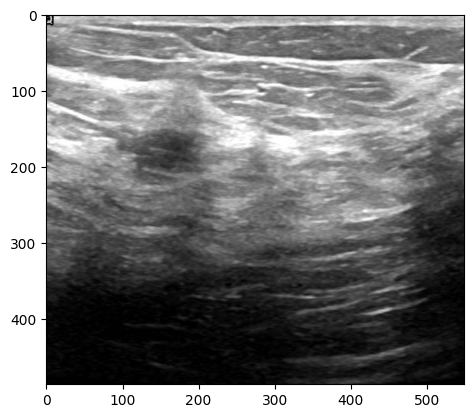

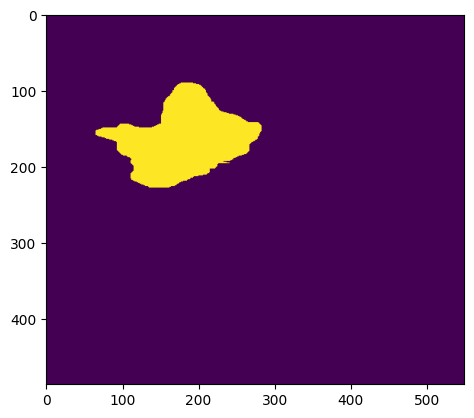

In [ ]:
#displaying certain images:
import matplotlib.pyplot as plt

img_path = "/root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT/malignant/malignant (99).png"
mask_img_path = '/root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT/malignant/malignant (99)_mask.png'

# If using PIL:
img = Image.open(img_path)
mask_img = Image.open(mask_img_path)

transform = transforms.ToTensor()
img_tensor = transform(img)
print(img_tensor.shape)
mask_img_tensor = transform(mask_img)
# Prepare for display
img_tensor = img_tensor.permute(1, 2, 0)
mask_img_tensor = mask_img_tensor.permute(1,2,0)
# If you have a batch dimension: image_tensor = image_tensor.squeeze(0)

# Display the image
plt.imshow(img_tensor)
plt.show()
plt.imshow(mask_img_tensor)
plt.show()

In [ ]:
import random

class BreastCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None, transform1=None):
        """
        Args:
            root_dir (str): Root directory containing 'normal', 'malignant', 'benign'.
            transform (callable, optional): Transform to apply to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.transform1 = transform1
        self.image_paths = []
        self.mask_paths = []

        # Iterate over normal, malignant, benign folders
        for category in ['normal', 'malignant', 'benign']:
            category_path = os.path.join(root_dir, category)
            images = sorted([f for f in os.listdir(category_path) if "_mask" not in f])  # Exclude masks

            for img in images:
                img_path = os.path.join(category_path, img)
                mask_path = os.path.join(category_path, img.replace('.png', '_mask.png'))  # Assuming PNG format

                if os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

        # Shuffle the dataset before splitting
        combined = list(zip(self.image_paths, self.mask_paths))
        random.shuffle(combined)
        self.image_paths, self.mask_paths = zip(*combined)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform1(mask)

        return image, mask  # Image as input, mask as label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for consistency
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform1 = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for consistency
    transforms.ToTensor()         # Convert to tensor
])

dataset = BreastCancerDataset(root_dir=main_dir, transform=transform, transform1=transform1)

train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Load dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Example: Iterate through data
for images, masks in train_loader:
    print(images.shape, masks.shape)
    print( masks[1])
    break


torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as tf

class DoubleConv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)

class UNET(nn.Module):
  def __init__(self, in_ch=3, out_ch=1, features=[64, 128, 256, 512]):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #goind down the unet
    for feature in features:
      self.downs.append(
          DoubleConv(in_ch, feature)
      )
      in_ch = feature

    #goind up the unet
    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(2*feature, feature, kernel_size=2, stride=2)
      )
      self.ups.append(
          DoubleConv(2*feature, feature)
      )

    self.bottomLayer = DoubleConv(features[-1], features[-1]*2)
    self.final_layer = nn.Conv2d(features[0], out_ch, kernel_size=1)

  def forward(self, x):
    skip_connections = []
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottomLayer(x)
    skip_connections = skip_connections[::-1]

    for ind in range(0, len(self.ups), 2):
      x = self.ups[ind](x)
      skip_connection = skip_connections[ind//2]

      if x.shape != skip_connection.shape:
        x = tf.resize(x, skip_connection.shape[2:])

      concat_x = torch.cat((skip_connection, x), dim=1)
      x = self.ups[ind+1](concat_x)

    return self.final_layer(x)

#test the above model
test_input = torch.randn((3, 1, 161, 161))
model = UNET(in_ch = 1, out_ch=1)
preds = model(test_input)
preds.shape

torch.Size([3, 1, 161, 161])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    return avg_loss

In [ ]:
def iou_score(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    union = (preds + targets).clamp(0, 1).sum()
    return (intersection + 1e-6) / (union + 1e-6)

def test_model(model, test_loader, device):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            iou = iou_score(outputs, masks)
            iou_scores.append(iou)

    avg_iou = sum(iou_scores) / len(iou_scores)
    return avg_iou

In [ ]:
model = UNET()
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
train_losses = []
iou_at_epoch = []
for epoch in range(num_epochs):
  train_loss = train_model(model, train_loader, optimizer, criterion, device)
  train_losses.append(train_loss)
  test_iou = test_model(model, test_loader, device)
  iou_at_epoch.append(test_iou)

  print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, IoU: {test_iou:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'unet_breast_cancer_segmentation.pth')


Epoch [1/25] - Loss: 0.4094, IoU: 0.0594


Epoch [2/25] - Loss: 0.3066, IoU: 0.0000


Epoch [3/25] - Loss: 0.2695, IoU: 0.0006


Epoch [4/25] - Loss: 0.2415, IoU: 0.0512


Epoch [5/25] - Loss: 0.2180, IoU: 0.1384


Epoch [6/25] - Loss: 0.2060, IoU: 0.1786


Epoch [7/25] - Loss: 0.1857, IoU: 0.0137


Epoch [8/25] - Loss: 0.1874, IoU: 0.2627


Epoch [9/25] - Loss: 0.1729, IoU: 0.0056


Epoch [10/25] - Loss: 0.1663, IoU: 0.2591


Epoch [11/25] - Loss: 0.1638, IoU: 0.2425


Epoch [12/25] - Loss: 0.1673, IoU: 0.2393


Epoch [13/25] - Loss: 0.1734, IoU: 0.0300


KeyboardInterrupt: 

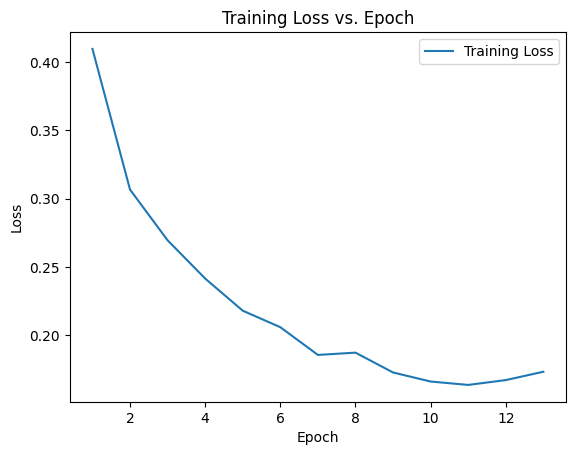

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()
plt.show()

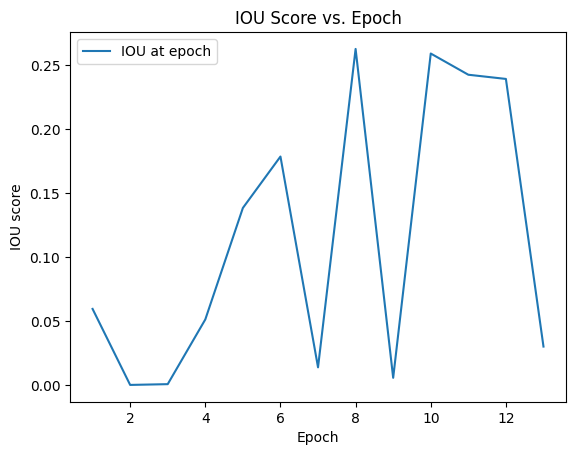

In [ ]:
import numpy as np
iou_at_epoch = [iou.cpu().item() for iou in iou_at_epoch]

plt.plot(range(1, len(iou_at_epoch) + 1), iou_at_epoch, label='IOU at epoch')
plt.xlabel('Epoch')
plt.ylabel('IOU score')
plt.title('IOU Score vs. Epoch')
plt.legend()
plt.show()

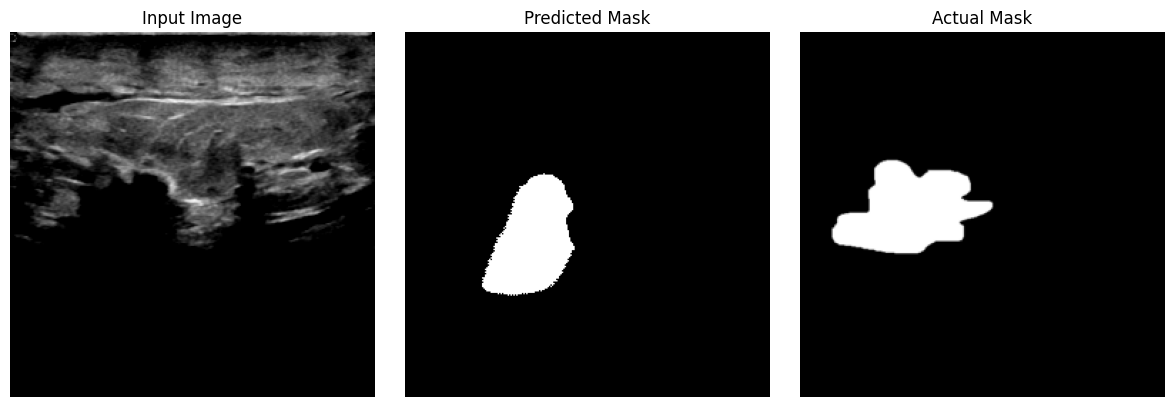

In [ ]:
image = Image.open(main_dir + '/malignant/malignant (4).png').convert("RGB")
mask = Image.open(main_dir + '/malignant/malignant (4)_mask.png').convert("L")

input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
input_mask = transform1(mask).unsqueeze(0).to(device)     # Add batch dimension

with torch.no_grad():
    prediction = model(input_image)
    predicted_mask = (torch.sigmoid(prediction) > 0.5).float()

# Remove batch dimension for visualization
input_image = input_image.squeeze(0).permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
predicted_mask = predicted_mask.squeeze(0).squeeze(0)  # (1, 256, 256) -> (256, 256)
input_mask = input_mask.squeeze(0).squeeze(0)          # Ground truth mask

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_image.cpu())
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask.cpu(), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(input_mask.cpu(), cmap='gray')
plt.title("Actual Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
